# Propensity to fund mortgages: refined models

Author: Yoann Pradat

Competition hosted on crowdanalytix.com. It aims at predicting whether a mortgage will be funded or not based on applicant's data. It is therefore a binary classification problem.

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import pandas as pd

import os
import sys

import itertools
import time
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from imblearn.over_sampling import SMOTENC

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
class Ignore(BaseEstimator, TransformerMixin):
    def __init__(self, cols_ignore):
        self.cols_ignore=cols_ignore
    def fit(self, X, y):
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_ignore:
            del Xc[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, cols_num, eps=1e-1):
        self.cols_num=cols_num
        self.esp = eps
    def fit(self, X, y):
        self.tds_upper = X.tds.quantile(0.99)
        self.gds_upper = X.gds.quantile(0.99)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        # Indicator of extreme values
        Xc.loc[:, 'tds_le_0'] = np.where(Xc.tds <= 0, 1, 0)
        Xc.loc[:, 'ltv_gt_80'] = np.where(Xc.ltv > 80, 1, 0)
        # Clip too extreme values of tds and tmgds
        Xc.loc[:, 'tds'] = Xc.tds.clip(lower=0, upper=self.tds_upper)
        Xc.loc[:, 'gds'] = Xc.gds.clip(lower=0, upper=self.gds_upper)
        # Log transform
        eps = 1e-1
        for x in self.cols_num:
            Xc.loc[:, x] = np.log10(Xc[x] + eps)
        # As gds and tds are very correlated (0.99) we will only keep tds and add feature tds - gds
        Xc.loc[:, 'tmgds'] = Xc.loc[:, 'tds'] - Xc.loc[:, 'gds']
        del Xc['gds']
        return Xc  

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, center=True, norm_ord=2):
        self.center=center
        self.norm_ord=norm_ord
    def fit(self, X, y):
        n, _ = X.shape
        self.centers = {}
        self.norms = {}
        for x in X:
            if X[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                center = np.mean(X[x])
                norm = np.linalg.norm(X[x]-center)
                self.centers[x] = center
                self.norms[x] = norm/np.sqrt(n)
            else:
                norm = np.linalg.norm(X[x]-center, ord=norm_ord)
                self.norms[x] = norm/np.sqrt(n)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in Xc:
            if Xc[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                Xc.loc[:, x] = (Xc[x]-self.centers[x])/self.norms[x]
            else:
                Xc.loc[:, x] = Xc[x]/self.norms[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

class HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_lim=0.005):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.category_other = {}
        for x, category in zip(self.cols_onehot, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
        Xc = pd.DataFrame.copy(X)
        for i, x in enumerate(self.cols_onehot):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        self.categories = [Xc[x].unique() for x in self.cols_onehot]
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(Xc[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        Xdummy = self.onehotenc.transform(Xc[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            if 'other' in category:
                del Xdummy['%s_%s' % (x, 'other')]
            else:
                del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class LabEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, categories, other_lim=0.005):
        self.cols_cat = cols_cat
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.encoders = {}
        self.category_other = {}
        for x, category in zip(self.cols_cat, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
            
        Xc = pd.DataFrame.copy(X)
        self.categories = []
        for i, x in enumerate(self.cols_cat):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            self.categories.append(Xc[x].unique())
            encoder = LabelEncoder()
            encoder.fit(Xc[x])
            self.encoders[x] = encoder
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_cat:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
            Xc.loc[:, x] = Xc.loc[:, x].astype(str)
            Xc.loc[:, x] = self.encoders[x].transform(Xc[x])
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

def plot_learning_curve(param_grid, best_params, cv_results, params_logscale=[]):
    best_params_plot = {}
    for param_n, param_v in param_grid.items():
        if len(param_v) > 1:
            best_params_plot[param_n] = best_params[param_n]           
    ncols = 2
    nrows = np.int(np.ceil(len(best_params_plot)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ax = ax.flatten()
    
    for i, (param_n, param_v) in enumerate(best_params_plot.items()):
        best_idx = []
        for idx, params  in enumerate(cv_results['params']):
            if all([params[x] == best_params[x] for x in best_params.keys() if x!=param_n]):
                best_idx.append(idx)
                
        param_values = np.array([cv_results['params'][idx][param_n] for idx in best_idx])
        train_scores_mean = np.array([cv_results['mean_train_score'][idx] for idx in best_idx])
        train_scores_std = np.array([cv_results['std_train_score'][idx] for idx in best_idx])
        test_scores_mean = np.array([cv_results['mean_test_score'][idx] for idx in best_idx])
        test_scores_std = np.array([cv_results['std_test_score'][idx] for idx in best_idx])
        
        ax[i].grid()
        ax[i].fill_between(param_values, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax[i].fill_between(param_values, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax[i].plot(param_values, train_scores_mean, 'o-', color="r", label="Training score")
        ax[i].plot(param_values, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[i].set_title('Learning curve for %s' % param_n, fontsize=18, fontweight='bold')
        if param_n in params_logscale:
            ax[i].set_xscale('log')
        ax[i].legend(loc="best")
    if i < 2*nrows-1:
        ax[-1].axis('off')
    plt.show(fig)
    
# Function useful to compare coefficients
# Default parameters are for comparison across the 5 splits

def plot_compare_coeffs(list_coeffs, title, list_positions = [-3.5, -1.5, 0, 1.5, 3.5], 
                        list_colors = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_ecolors = ['lightsalmon', 'palegreen', 'lightgray', 'lightskyblue', 'palegoldenrod'], 
                        list_els=['-', '-', '-', '-', '-'], 
                        list_colors_labels = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_labels = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5'], 
                        list_lgd_ls=None, 
                        list_lgd_ls_labels=None, 
                        list_format=['o', 'o', 'o', 'o', 'o']): 
    
    n_coeffs = list_coeffs[0].shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))

    for i, col, ecol, coeffs, els, fmt in zip(list_positions, list_colors, list_ecolors, list_coeffs, list_els, list_format):
        eb = ax.errorbar(x=np.arange(n_coeffs) + i / 10, 
                         y=coeffs.values, 
                         yerr=[coeffs.values, np.zeros(n_coeffs)],
                        fmt=fmt, color=col, ecolor=ecol, elinewidth=3, capsize=0)
        eb[-1][0].set_linestyle(els)

    ax.set_xticks(np.arange(-1, n_coeffs + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = coeffs.index[i - 1][0:20]
    ax.set_xticklabels(labels)

    if n_coeffs >= 15:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('coef', fontweight='bold', fontsize=20)
    ax.set_title("Coeffs of %s" % title, fontweight='bold', size=25)

    ax.xaxis.grid(which='major', linewidth=0.2)
    ax.yaxis.grid(which='major', linewidth=0.35, linestyle="--")
    ax.axhline(0, color='gray', linewidth=0.5)

    custom_lines = []
    for c in list_colors_labels:
        custom_lines.append(Line2D([0], [0], color=c, ls="-", lw=4))

    if list_lgd_ls_labels is None:
        ax.legend(custom_lines, list_labels)
    else:
        custom_lines.append(Line2D([0], [0], color='gray', ls='-', lw=0))
        for ls in list_lgd_ls:
            custom_lines.append(Line2D([0], [0], color='gray', ls=ls, lw=2))
        ax.legend(custom_lines, list_labels+['']+list_lgd_ls_labels)

    if n_coeffs >= 15:
        fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.90, wspace=0.4)
    else:
        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90)

    plt.show(fig)

def f1_macro(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    precisions = {}
    recalls = {}
    f1s = {}
    for cl in np.unique(y_true):
        if sum(y_pred==cl)==0:
            precision = 0
        else:
            precision = sum((y_pred==cl) & (y_true==cl))/sum(y_pred==cl)
        if sum(y_true==cl)==0:
            print("Warning! Ill-defined f1-score as no label of the class is in y_true")
            recall = 0
        else:
            recall = sum((y_pred==cl) & (y_true==cl))/sum(y_true==cl)
        
        if recall+precision == 0:
            f1 = 0
        else:
            f1 = 2*recall*precision/(recall + precision)
        precisions[cl] = precision
        recalls[cl] = recall
        f1s[cl] = f1
    return precisions, recalls, f1s

In [3]:
class MortgageData(object):
    def __init__(self, train_file="../data/CAX_MortgageModeling_Train.csv", test_file="../data/CAX_MortgageModeling_Test.csv", 
                 encoder="Hot", n_splits=5, random_state=0, other_lim=0.005):
        self.n_splits = n_splits
        self.random_state = random_state
        self.other_lim = other_lim
        self.resampled = False
        # Load data
        data_train = pd.read_csv(train_file) 
        data_test = pd.read_csv(test_file, usecols=lambda x: x not in ["RESULT"]) 
        
        # Lower case column names
        data_train.columns = list(map(str.lower, data_train.columns))
        data_test.columns = list(map(str.lower, data_test.columns))
        
        # Categorical features
        cols_cat = ['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
                   'gender', 'income type', 'naics code']
        data_train[cols_cat] = data_train[cols_cat].astype('object')
        data_test[cols_cat] = data_test[cols_cat].astype('object')

        # Compartimentalize features
        self.X_train = data_train.iloc[:, :-1]  
        self.y_train = data_train.iloc[:, -1].map({"NOT FUNDED": 0, "FUNDED":1})
        self.X_test = data_test
        cols_ignore = ['unique_id', 'mortgage number', 'fsa']
        cols_cat = [x for x in self.X_train if self.X_train[x].dtype==object and x not in cols_ignore]
        cols_num = [x for x in self.X_train.columns if x not in cols_cat and x not in cols_ignore]

        # Make sure all categories of every categorical feature is here
        X_all = pd.concat((self.X_train, self.X_test), axis=0)
        categories = [X_all[x].unique() for x in cols_cat]
        del X_all

        if encoder=="Lab":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', LabEncoder(categories=categories,cols_cat=cols_cat,other_lim=other_lim))])
        elif encoder=="Hot":
            self.tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                                   ('preprocesser', Preprocesser(cols_num=cols_num)),
                                   ('scaler', Scaler()),
                                   ('encoder', HotEncoder(categories=categories,cols_onehot=cols_cat,other_lim=other_lim))])
        else:
            raise ValueError("Please choose between 'Hot' and 'Lab' for encoding of categorical variables.")
        
        # Transform the data
        self.X_ttrain = self.tpipe.fit_transform(self.X_train, self.y_train)
        self.X_ttest = self.tpipe.transform(self.X_test)
        self.n_input = self.X_ttrain.shape[1]
            
        # Resample for balancing data. Used only if prescribed
        categorical_features = [x for x in self.X_ttrain.columns if any([s in x for s in cols_cat])]
        categorical_features = [self.X_ttrain.columns.get_loc(x) for x in categorical_features]
        self.sm = SMOTENC(categorical_features=categorical_features, 
                          sampling_strategy='auto',
                          random_state=random_state,
                          k_neighbors=5,
                          n_jobs=1)
        
        self.categorical_features = categorical_features
        self.strat_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.splits = []
        for idx_train, idx_test in self.strat_cv.split(self.X_ttrain, self.y_train):
            self.splits.append((idx_train, idx_test))

    def resample(self, index=None):
        if index is None:
            self.X_ttrain, self.y_train = self.sm.fit_resample(self.X_ttrain, self.y_train)
        else:
            # Split before resampling
            idx_train, idx_test = self.splits[index]
            self.X_tttrain, self.y_ttrain = self.X_ttrain.iloc[idx_train], self.y_train.iloc[idx_train]
            self.X_tttrain, self.y_ttrain = self.sm.fit_resample(self.X_tttrain, self.y_ttrain)
            self.X_tttrain = pd.DataFrame(self.X_tttrain, columns=self.X_ttrain.columns)
            self.y_ttrain = pd.Series(self.y_ttrain)
            self.X_tttest, self.y_ttest = self.X_ttrain.iloc[idx_test], self.y_train.iloc[idx_test]
        self.resampled = True
        return self

    def get_train(self, index=None):
        if index is None:
            return self.X_ttrain, self.y_train
        else:
            if self.resampled:
                return self.X_tttrain, self.X_tttest, self.y_ttrain, self.y_ttest
            else:
                idx_train, idx_test = self.splits[index]
                self.X_tttrain, self.y_ttrain = self.X_ttrain.iloc[idx_train], self.y_train.iloc[idx_train]
                self.X_tttest, self.y_ttest = self.X_ttrain.iloc[idx_test], self.y_train.iloc[idx_test]
                return self.X_tttrain, self.X_tttest, self.y_ttrain, self.y_ttest

    def get_test(self):
        return self.X_ttest


In [6]:
random_state = 0

# II. Models

## Random Forest

In [7]:
mortgage_data = MortgageData(encoder="Hot")
X_ttrain, y_train = mortgage_data.get_train()
X_ttest = mortgage_data.get_test()

In [9]:
%%time
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [30, 40, 50], 
              'max_depth': [15]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=mortgage_data.strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(X_ttrain, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   15.5s finished


CPU times: user 2.61 s, sys: 174 ms, total: 2.78 s
Wall time: 18 s


In [10]:
y_pred_train = grid.best_estimator_.predict(X_ttrain)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)
print("="*40)
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Best params {'max_depth': 15, 'n_estimators': 50}
Class 0 | precision 0.52; recall 0.7666; f1 0.6197 
Class 1 | precision 0.9286; recall 0.8111; f1 0.8659 


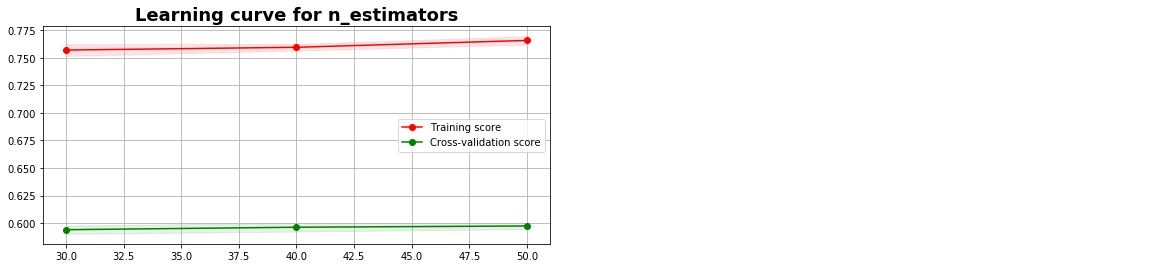

In [11]:
plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

## Neural Network

In [176]:
# See PyTorch implementation in scripts
# The class imbalance is corrected in the train files

## LightGBM

In [12]:
def f1_macro_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.where(y_pred > 0.7, 1, 0)
    return 'f1_macro', f1_score(y_true, y_pred, average='macro'), True

In [23]:
class GBMGridSearch(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, param_grid, scoring, cv, verbose):
        self.cols_cat = cols_cat
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        
    def fit(self, X, y):
        self.cv_results_= {}
        self.best_params_ = {}
        splits = []
        for idx_train, idx_test in self.cv.split(X, y):
            splits.append((idx_train, idx_test))
        
        n_splits = self.cv.get_n_splits()
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        params_combinations = list(itertools.product(*(param_values)))
        n_combinations = len(params_combinations)
        
        for i in range(n_splits):
            self.cv_results_['split%d_train_score'%i] = np.zeros(n_combinations)
            self.cv_results_['split%d_test_score'%i] = np.zeros(n_combinations)
        self.cv_results_['mean_train_score'] = np.zeros(n_combinations)
        self.cv_results_['std_train_score'] = np.zeros(n_combinations)
        self.cv_results_['mean_test_score'] = np.zeros(n_combinations)
        self.cv_results_['std_test_score'] = np.zeros(n_combinations)
        self.cv_results_['params'] = []
        
        st_time = time.time()
        self.best_score_ = 0
        self.best_params_ = {}
        self.best_estimator_ = {}
        
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        for j, params in enumerate(params_combinations):
            d_params = {k:v for (k,v) in zip(param_names, params)}
            str_d_params = '; '.join(["%s: %s" % (str(k), str(v)) for k,v in d_params.items()])
            if self.verbose > 0:
                print("[fit %d/%d] %.3g s| params %s"%(j+1, n_combinations, time.time()-st_time, str_d_params))

            scores_train = []
            scores_test = []
            for i, (idx_train, idx_test) in enumerate(splits):
                lgb_train = lgb.Dataset(X.iloc[idx_train], y.iloc[idx_train], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)
                lgb_test = lgb.Dataset(X.iloc[idx_test], y.iloc[idx_test], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)

                gbm = lgb.train(d_params,
                                lgb_train,
                                feval=f1_macro_eval,
                                valid_sets=[lgb_test],               
                                valid_names=['test'],
                                verbose_eval=False)

                _, score_train, _ = self.scoring(gbm.predict(X.loc[idx_train]), lgb_train)
                _, score_test, _ = self.scoring(gbm.predict(X.loc[idx_test]), lgb_test)
                scores_train.append(score_train)
                scores_test.append(score_test)
                self.cv_results_['split%d_train_score'%i][j] = score_train
                self.cv_results_['split%d_test_score'%i][j] = score_test
                if self.verbose > 1:
                    print("[cv %d/%d] | train score %.3g ; test score % .3g" % (i+1, n_splits, score_train, score_test))

            if np.mean(scores_test) > self.best_score_:
                self.best_score_ = np.mean(scores_test)
                self.best_params_ = d_params
                self.best_estimator_ = gbm
                
            self.cv_results_['mean_train_score'][j] = np.mean(scores_train)
            self.cv_results_['std_train_score'][j] = np.std(scores_train)
            self.cv_results_['mean_test_score'][j] = np.mean(scores_test)
            self.cv_results_['std_test_score'][j] = np.std(scores_test)
            self.cv_results_['params'].append(d_params)
        return self



In [31]:
def f1_macro_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.where(y_pred > 0.75, 1, 0)
    return 'f1_macro', f1_score(y_true, y_pred, average='macro'), True

class GBMGridSearch(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, param_grid, scoring, cv, verbose):
        self.cols_cat = cols_cat
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        
    def fit(self, X, y):
        self.cv_results_= {}
        self.best_params_ = {}
        splits = []
        for idx_train, idx_test in self.cv.split(X, y):
            splits.append((idx_train, idx_test))
        
        n_splits = self.cv.get_n_splits()
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        params_combinations = list(itertools.product(*(param_values)))
        n_combinations = len(params_combinations)
        
        for i in range(n_splits):
            self.cv_results_['split%d_train_score'%i] = np.zeros(n_combinations)
            self.cv_results_['split%d_test_score'%i] = np.zeros(n_combinations)
        self.cv_results_['mean_train_score'] = np.zeros(n_combinations)
        self.cv_results_['std_train_score'] = np.zeros(n_combinations)
        self.cv_results_['mean_test_score'] = np.zeros(n_combinations)
        self.cv_results_['std_test_score'] = np.zeros(n_combinations)
        self.cv_results_['params'] = []
        
        st_time = time.time()
        self.best_score_ = 0
        self.best_params_ = {}
        self.best_estimator_ = {}
        
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        for j, params in enumerate(params_combinations):
            d_params = {k:v for (k,v) in zip(param_names, params)}
            str_d_params = '; '.join(["%s: %s" % (str(k), str(v)) for k,v in d_params.items()])
            if self.verbose > 0:
                print("[fit %d/%d] %.3g s| params %s"%(j+1, n_combinations, time.time()-st_time, str_d_params))

            scores_train = []
            scores_test = []
            for i, (idx_train, idx_test) in enumerate(splits):
                lgb_train = lgb.Dataset(X.iloc[idx_train], y.iloc[idx_train], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)
                lgb_test = lgb.Dataset(X.iloc[idx_test], y.iloc[idx_test], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)

                gbm = lgb.train(d_params,
                                lgb_train,
                                feval=f1_macro_eval,
                                valid_sets=[lgb_test],               
                                valid_names=['test'],
                                verbose_eval=False)

                _, score_train, _ = self.scoring(gbm.predict(X.loc[idx_train]), lgb_train)
                _, score_test, _ = self.scoring(gbm.predict(X.loc[idx_test]), lgb_test)
                scores_train.append(score_train)
                scores_test.append(score_test)
                self.cv_results_['split%d_train_score'%i][j] = score_train
                self.cv_results_['split%d_test_score'%i][j] = score_test
                if self.verbose > 1:
                    print("[cv %d/%d] | train score %.3g ; test score % .3g" % (i+1, n_splits, score_train, score_test))

            if np.mean(scores_test) > self.best_score_:
                self.best_score_ = np.mean(scores_test)
                self.best_params_ = d_params
                self.best_estimator_ = gbm
                
            self.cv_results_['mean_train_score'][j] = np.mean(scores_train)
            self.cv_results_['std_train_score'][j] = np.std(scores_train)
            self.cv_results_['mean_test_score'][j] = np.mean(scores_test)
            self.cv_results_['std_test_score'][j] = np.std(scores_test)
            self.cv_results_['params'].append(d_params)
        return self

In [34]:
mortgage_data = MortgageData(encoder="Lab")
X_ttrain, y_train = mortgage_data.get_train()
X_ttest = mortgage_data.get_test()


categorical_features = mortgage_data.categorical_features
cols_cat = list(X_ttrain.iloc[:, categorical_features].columns)
strat_cv = mortgage_data.strat_cv

In [35]:
%%time 

# specify your configurations as a dict
param_grid = {'boosting_type': ['gbdt'],
              'objective': ['binary'],
              'metric': ['binary_logloss'],
              'num_leaves': [40],
              'learning_rate': [0.05],
              'feature_fraction': [0.6],
              'bagging_fraction': [0.9],
              'bagging_freq': [5],
              'num_boost_round': [400],
              'early_stopping_rounds': [25],
              'verbose': [0]}

gbm_grid = GBMGridSearch(cols_cat=mortgage_data.categorical_features, 
                         param_grid=param_grid, 
                         scoring=f1_macro_eval, 
                         cv=strat_cv, 
                         verbose=2)

warnings.filterwarnings('ignore')
gbm_grid.fit(X_ttrain, y_train)

[fit 1/1] 0.000193 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 40; learning_rate: 0.05; feature_fraction: 0.6; bagging_fraction: 0.9; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.697 ; test score  0.62
[cv 2/5] | train score 0.636 ; test score  0.615
[cv 3/5] | train score 0.659 ; test score  0.612
[cv 4/5] | train score 0.666 ; test score  0.615
[cv 5/5] | train score 0.648 ; test score  0.615
CPU times: user 16.6 s, sys: 2.12 s, total: 18.7 s
Wall time: 5.34 s


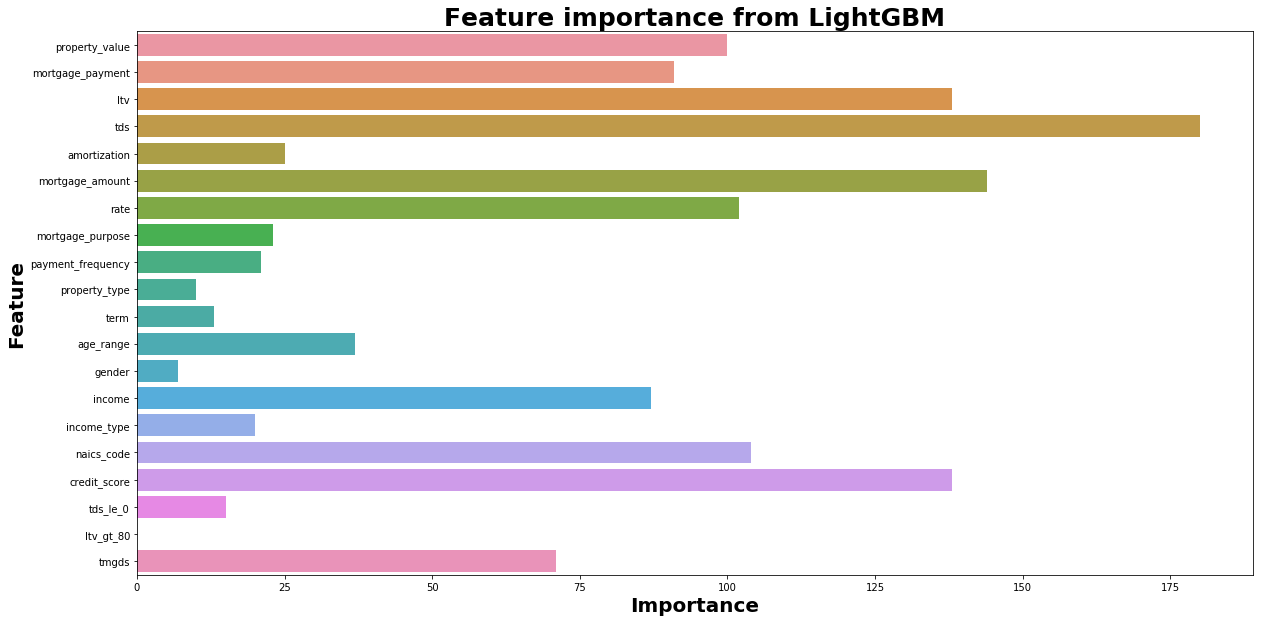

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

df_feat = pd.DataFrame({'Feature': gbm_grid.best_estimator_.feature_name(), 
                        'Importance': gbm_grid.best_estimator_.feature_importance()})
sns.barplot(x='Importance', y='Feature', data=df_feat, ax=ax)
ax.set_title("Feature importance from LightGBM", fontweight='bold', fontsize=25)
ax.set_xlabel("Importance", fontweight='bold', fontsize=20)
ax.set_ylabel("Feature", fontweight='bold', fontsize=20)
plt.show(fig)

In [37]:
%%time
# specify your configurations as a dict
param_grid = {'boosting_type': ['gbdt'],
              'objective': ['binary'],
              'metric': ['binary_logloss'],
              'num_leaves': [25],
              'learning_rate': [0.05],
              'feature_fraction': np.r_[0.4:0.95:0.05],
              'bagging_fraction': [0.9],
              'bagging_freq': [5],
              'num_boost_round': [400],
              'early_stopping_rounds': [25],
              'verbose': [0]}

gbm_grid = GBMGridSearch(cols_cat=cols_cat, 
                         param_grid=param_grid, 
                         scoring=f1_macro_eval, 
                         cv=strat_cv, 
                         verbose=2)

warnings.filterwarnings('ignore')
gbm_grid.fit(X_ttrain, y_train)

[fit 1/11] 3e-05 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 25; learning_rate: 0.05; feature_fraction: 0.4; bagging_fraction: 0.9; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.644 ; test score  0.617
[cv 2/5] | train score 0.639 ; test score  0.62
[cv 3/5] | train score 0.654 ; test score  0.616
[cv 4/5] | train score 0.662 ; test score  0.618
[cv 5/5] | train score 0.663 ; test score  0.624
[fit 2/11] 6.29 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 25; learning_rate: 0.05; feature_fraction: 0.45; bagging_fraction: 0.9; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.66 ; test score  0.616
[cv 2/5] | train score 0.657 ; test score  0.619
[cv 3/5] | train score 0.662 ; test score  0.617
[cv 4/5] | train score 0.656 ; test score  0.615
[cv 5/5] | train score 0.667 ; test score  0.623
[fit 3/11]

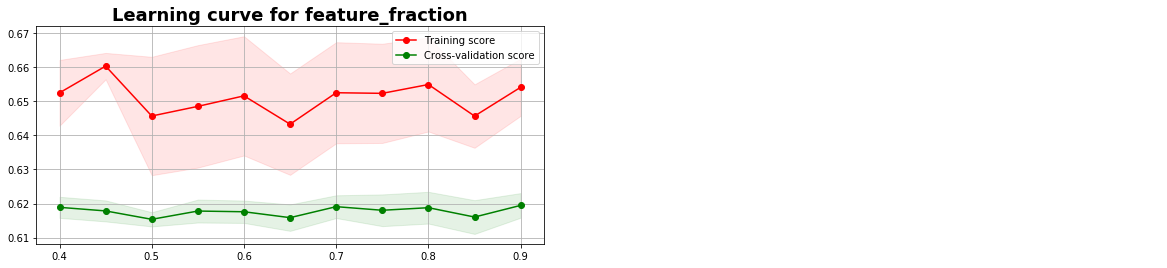

In [38]:
plot_learning_curve(param_grid, gbm_grid.best_params_, gbm_grid.cv_results_)

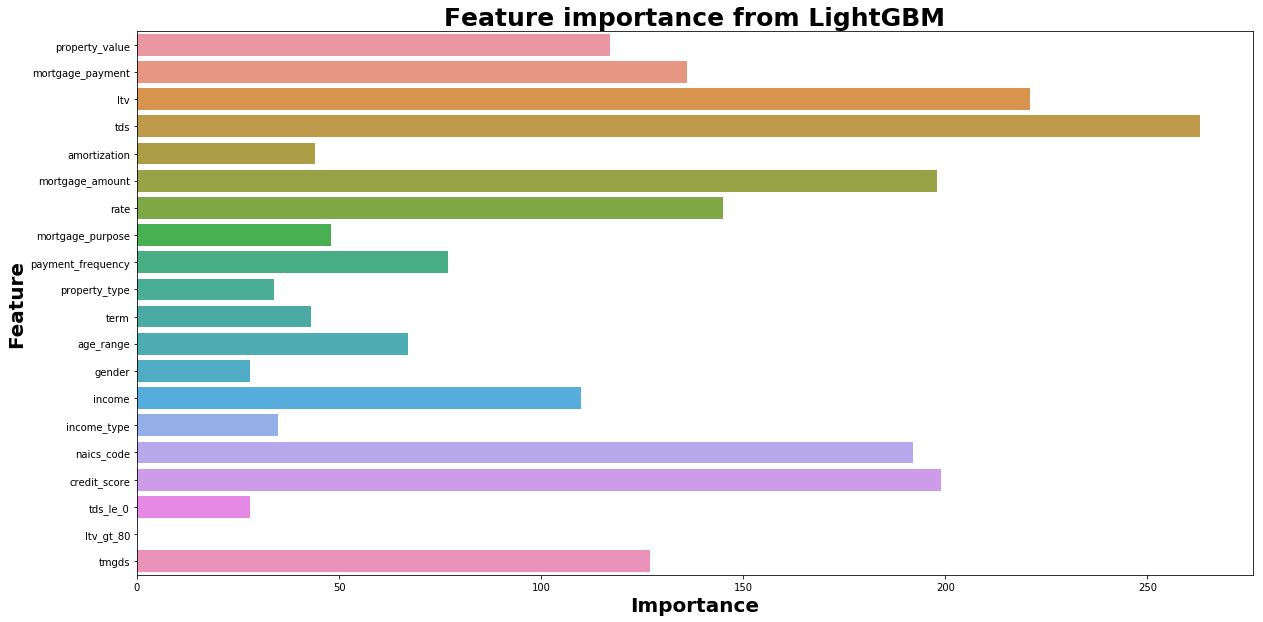

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

df_feat = pd.DataFrame({'Feature': gbm_grid.best_estimator_.feature_name(), 
                        'Importance': gbm_grid.best_estimator_.feature_importance()})
sns.barplot(x='Importance', y='Feature', data=df_feat, ax=ax)
ax.set_title("Feature importance from LightGBM", fontweight='bold', fontsize=25)
ax.set_xlabel("Importance", fontweight='bold', fontsize=20)
ax.set_ylabel("Feature", fontweight='bold', fontsize=20)
plt.show(fig)

### Bagging fraction

In [54]:
model_name = "LigthGBM"
model_type = "GBM"
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type

if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)


# specify your configurations as a dict
param_grid = {'boosting_type': ['gbdt'],
              'objective': ['binary'],
              'metric': ['binary_logloss'],
              'num_leaves': [25],
              'learning_rate': [0.05],
              'feature_fraction': [0.7],
              'bagging_fraction': np.r_[0.85:0.99:0.02],
              'bagging_freq': [5],
              'num_boost_round': [400],
              'early_stopping_rounds': [25],
              'verbose': [0]}

gbm_grid = GBMGridSearch(cols_cat=cols_cat, 
                         param_grid=param_grid, 
                         scoring=f1_macro_eval, 
                         cv=strat_cv, 
                         verbose=2,
                         path_model=path_model,
                         model_name=model_name)

warnings.filterwarnings('ignore')
gbm_grid.fit(X_ttrain, y_train)

[fit 1/8] 3.03e-05 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 25; learning_rate: 0.05; feature_fraction: 0.7; bagging_fraction: 0.85; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.679 ; test score  0.629
[cv 2/5] | train score 0.657 ; test score  0.619
[cv 3/5] | train score 0.696 ; test score  0.621
[cv 4/5] | train score 0.667 ; test score  0.614
[cv 5/5] | train score 0.687 ; test score  0.627
[fit 2/8] 10.7 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 25; learning_rate: 0.05; feature_fraction: 0.7; bagging_fraction: 0.87; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.692 ; test score  0.627
[cv 2/5] | train score 0.657 ; test score  0.62
[cv 3/5] | train score 0.674 ; test score  0.616
[cv 4/5] | train score 0.688 ; test score  0.621
[cv 5/5] | train score 0.682 ; test score  0.624
[fit 3/

GBMGridSearch(cols_cat=['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range', 'gender', 'income type', 'naics code'],
       cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       model_name='LigthGBM',
       param_grid={'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['binary_logloss'], 'num_leaves': [25], 'learning_rate': [0.05], 'feature_fraction': [0.7], 'bagging_fraction': array([0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99]), 'bagging_freq': [5], 'num_boost_round': [400], 'early_stopping_rounds': [25], 'verbose': [0]},
       path_model='../trained_models/GBM',
       scoring=<function f1_macro_eval at 0x1a1fa61ae8>, verbose=2)

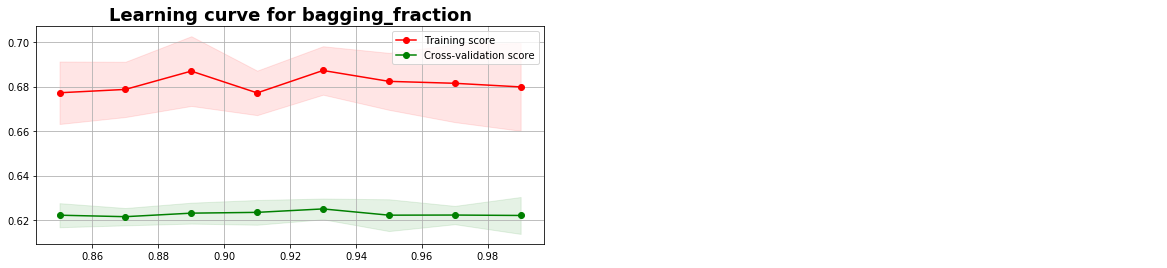

In [55]:
plot_learning_curve(param_grid, gbm_grid.best_params_, gbm_grid.cv_results_)

## ExtraTrees Classifier

In [190]:
from sklearn.ensemble import ExtraTreesClassifier

In [191]:
mortgage_data = MortgageData(encoder="Hot")
X_ttrain, y_train = mortgage_data.get_train()
X_ttest = mortgage_data.get_test()

In [192]:
%%time
clf = ExtraTreesClassifier(criterion='gini',
                           max_depth=15,
                           max_features='sqrt',
                           min_samples_leaf=1,
                           max_leaf_nodes=None,
                           random_state=random_state,
                           class_weight="balanced")

param_grid = {"n_estimators": [50, 100, 200, 400, 600],
              "min_samples_split": [2, 5, 20, 40, 60],
              "bootstrap": [True, False]}

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

grid = grid.fit(X_ttrain, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.8min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed: 14.3min finished


CPU times: user 3.6 s, sys: 338 ms, total: 3.94 s
Wall time: 14min 19s


Best params {'bootstrap': True, 'min_samples_split': 2, 'n_estimators': 100}
Class 0 | precision 0.3761; recall 0.6991; f1 0.4891 
Class 1 | precision 0.8958; recall 0.6904; f1 0.7798 


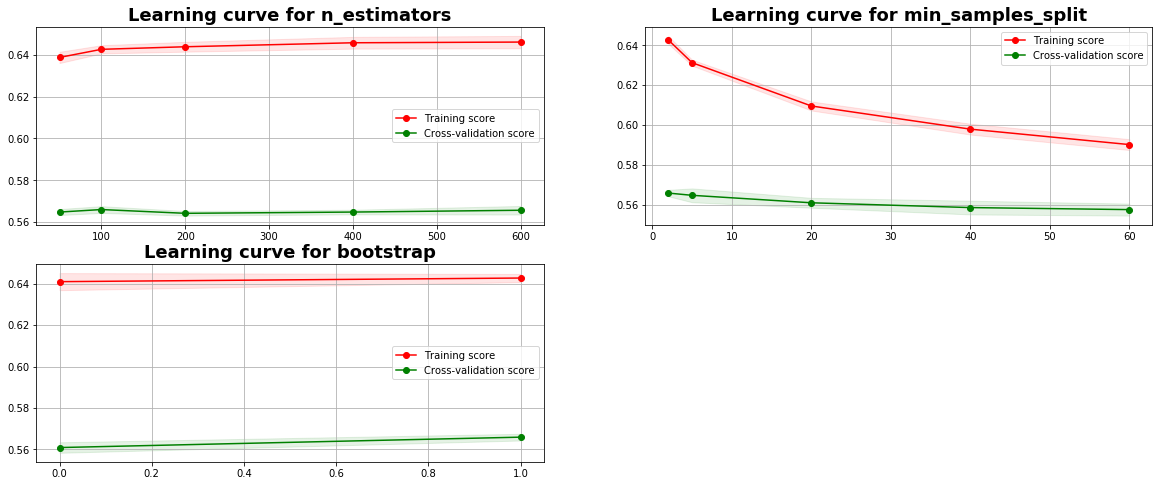

In [194]:
y_pred_train = grid.best_estimator_.predict(X_ttrain)
recalls, precisions, f1s = f1_macro(y_pred_train, y_train)
print("="*40)
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

plot_learning_curve(param_grid, grid.best_params_, grid.cv_results_, params_logscale=['C'])

## II.2 Imbalance learning

### Ensemble split 1

In [148]:
df = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_15_split_1.csv")[['Index test', 'Prediction']]

df_2 = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_20_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_2, on='Index test')
df_3 = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_30_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_3, on='Index test')

df_4 = pd.read_csv("../predictions/MLP_1/MLPNet3_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_4, on='Index test')

df_5 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_None_10_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_5, on='Index test')
df_6 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_10_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_6, on='Index test')
df_7 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_15_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_7, on='Index test')
df_8 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_20_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_8, on='Index test')
df_9 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_10_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_9, on='Index test')
df_10 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_15_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_10, on='Index test')
df_11 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_20_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_11, on='Index test')
df_12 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_10_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_12, on='Index test')
df_13 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_15_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_13, on='Index test')
df_14 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_20_split_1.csv")[['Index test', 'Prediction']]
df = df.merge(df_14, on='Index test')

In [151]:
X_ttrain, y_train = mortgage_data.get_train()

In [153]:
idx_train, idx_test = mortgage_data.splits[0]

In [165]:
del df["Result_Predicted"]
df.loc[:, "Result_Predicted"] = np.where(df.iloc[:, 1:].sum(axis=1) >= 7, 1, 0)

In [166]:
df.loc[:, "Truth"] = y_train.iloc[idx_test].values

In [199]:
del df["Result_Predicted"]
df.loc[:, "Result_Predicted"] = np.where(df.iloc[:, 1:].sum(axis=1) >= 14, 1, 0)

In [200]:
f1_score(df["Truth"].values, df["Result_Predicted"], average="macro")

0.5910892951819715

In [168]:
df.head(50)

,Index test,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Prediction_x,Prediction_y,Result_Predicted,Truth
0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
1,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,24.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,36.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
6,55.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,65.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
8,76.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,78.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df.loc[:, "Truth"] = y_train.iloc[idx_test].values

In [ ]:
X_ttmortgage_data.get_test(index=0)

### Ensemble

In [201]:
df = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_15_submission.csv")

df_2 = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_20_submission.csv")
df = df.merge(df_2, on='Unique_ID')
df_3 = pd.read_csv("../predictions/LGBM_1/lgb_gbdt_30_submission.csv")
df = df.merge(df_3, on='Unique_ID')

df_4 = pd.read_csv("../predictions/MLP_1/MLPNet3_submission.csv")
df = df.merge(df_4, on='Unique_ID')

df_5 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_None_10_submission.csv")
df = df.merge(df_5, on='Unique_ID')
df_6 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_10_submission.csv")
df = df.merge(df_6, on='Unique_ID')
df_7 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_15_submission.csv")
df = df.merge(df_7, on='Unique_ID')
df_8 = pd.read_csv("../predictions/RandomForest_1/rf_entropy_sqrt_20_submission.csv")
df = df.merge(df_8, on='Unique_ID')
df_9 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_10_submission.csv")
df = df.merge(df_9, on='Unique_ID')
df_10 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_15_submission.csv")
df = df.merge(df_10, on='Unique_ID')
df_11 = pd.read_csv("../predictions/RandomForest_1/rf_gini_None_20_submission.csv")
df = df.merge(df_11, on='Unique_ID')
df_12 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_10_submission.csv")
df = df.merge(df_12, on='Unique_ID')
df_13 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_15_submission.csv")
df = df.merge(df_13, on='Unique_ID')
df_14 = pd.read_csv("../predictions/RandomForest_1/rf_gini_sqrt_20_submission.csv")
df = df.merge(df_14, on='Unique_ID')

In [202]:
df.head(25)

,Unique_ID,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y
0,CAX_Test_1,FUNDED,NOT FUNDED,NOT FUNDED,FUNDED,FUNDED,NOT FUNDED,FUNDED,FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,FUNDED
1,CAX_Test_2,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
2,CAX_Test_3,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
3,CAX_Test_4,FUNDED,FUNDED,FUNDED,NOT FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
4,CAX_Test_5,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
5,CAX_Test_6,NOT FUNDED,NOT FUNDED,NOT FUNDED,FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED
6,CAX_Test_7,NOT FUNDED,NOT FUNDED,NOT FUNDED,FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED,NOT FUNDED
7,CAX_Test_8,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
8,CAX_Test_9,FUNDED,FUNDED,FUNDED,NOT FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED
9,CAX_Test_10,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED,FUNDED


In [203]:
for i in range(1, df.shape[1]):
    df.iloc[:, i] = df.iloc[:, i].map({"NOT FUNDED": 0, "FUNDED": 1})

In [208]:
df.loc[:, "Result_Predicted"] = np.where(df.iloc[:, 1:].sum(axis=1) >= 2, "FUNDED", "NOT FUNDED")

In [209]:
df.head()

,Unique_ID,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted_x,Result_Predicted_y,Result_Predicted
0,CAX_Test_1,1,0,0,1,1,0,1,1,0,0,0,0,0,1,FUNDED
1,CAX_Test_2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,FUNDED
2,CAX_Test_3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,FUNDED
3,CAX_Test_4,1,1,1,0,1,1,1,1,1,1,1,1,1,1,FUNDED
4,CAX_Test_5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,FUNDED


In [210]:
df[['Unique_ID', 'Result_Predicted']].to_csv("../submissions/sub_14models_thesh_2.csv", index=False)

In [207]:
del df["Result_Predicted"]